In [396]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [544]:
df = pd.read_csv("alves_lada_nature_data.csv")
df.head()
df_rau = np.asarray(df['radius_au'])
df_extinction = np.asarray(df['visual_extinction'])
df_len = df_rau.shape[0]

$\newcommand{\vec}[1]{{\mathbf{\boldsymbol{{#1}}}}}$

## Numerical solution to Lane-Emden equation.

### 1. Isothermal sphere in hydrostatic equilibrium.

* momentum equation: $\quad \rho \frac{d\vec{v}}{dt} + \vec{\nabla}P + \rho \vec{\nabla} \Phi = 0 \quad \longrightarrow \quad \frac{1}{\rho} \vec{\nabla}P = -\vec{\nabla} \Phi \quad$ (in hydrostatic equilibrium).
* gradient in spherical coordinates: $\quad \vec{\nabla} = \left( \frac{\partial}{\partial r} \vec{\hat{r}} + \frac{1}{r} \frac{\partial}{\partial \theta} \vec{\hat{\theta}} + \frac{1}{r \sin \theta} \frac{\partial}{\partial \phi} \vec{\hat{\phi}} \right) = \frac{d}{dr} \vec{\hat{r}} \quad$ (by spherical symmetry).
* isothermal sphere: $\quad P = c_s^2 \rho \quad \longrightarrow \quad \frac{1}{\rho} \frac{dP}{dr} = \frac{c_s^2}{\rho} \frac{d\rho}{dr} = c_s^2 \frac{d \ln \rho}{dr}$.
* hydrostatic equilibrium for isothermal sphere: $\quad \frac{1}{\rho} \vec{\nabla}P = -\vec{\nabla} \Phi \quad \longrightarrow \quad c_s^2 \frac{d \ln \rho}{dr} = -\frac{d\Phi}{dr}$.
* Poisson equation with spherical symmetry: $\quad \vec{\nabla}^2 \Phi = 4 \pi G \rho \quad \longrightarrow \quad \frac{1}{r^2} \frac{d}{dr} \left( r^2 \frac{d\Phi}{dr} \right) = 4 \pi G \rho$.  

### 2. Lane-Emden equation.
Let $\xi = (\sqrt{4 \pi G \rho_c}/c_s) r$ be the dimensionless radial parameter, and let $\psi = -\ln(\rho/\rho_c)$ be the scaled gravitational potential,
$$ c_s^2 \frac{d \ln \rho}{dr} = -\frac{d\Phi}{dr} \quad \longrightarrow \quad c_s^2 \int_0^r \frac{d \ln \rho}{dr} = - \int_0^r \frac{d\Phi}{dr} \quad \longrightarrow \quad \Phi(r) = -c_s^2 \ln \left(\frac{\rho}{\rho_c} \right) \quad \longrightarrow \quad \psi(\xi) = \frac{\Phi(r)}{c_s^2}, $$
where $\rho_c$ is the central density. Using the new variable $\xi$ in place of $r$,
$$ \frac{d}{dr} = \frac{\sqrt{4 \pi G \rho_c}}{c_s} \frac{d}{d\xi} \quad \text{and} \quad \frac{d}{dr}\left( r^2 \frac{d }{dr} \right) = \frac{\sqrt{4 \pi G \rho_c}}{c_s} \frac{d}{d\xi}\left( \frac{c_s^2}{4 \pi G \rho_c} \frac{\sqrt{4 \pi G \rho_c}}{c_s} \xi^2 \frac{d}{d\xi} \right) = \frac{d}{d\xi} \left( \xi^2 \frac{d}{d\xi} \right). $$
The Poisson equation becomes the Lane-Emden equation:
$$ -\frac{c_s^2}{4 \pi G \rho_c} \bigg[ \frac{1}{r^2} \frac{d}{dr} \ln \left( \frac{\rho}{\rho_c} \right) \bigg] = \frac{\rho}{\rho_c} \quad \longrightarrow \quad \frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\psi}{d\xi} \right)= e^{-\psi}. $$

### 3. Numerical solution for $\psi(x)$.
Write the second-order ODE in terms of two coupled ODEs.
$$ \frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\psi}{d\xi} \right)= e^{-\psi} \quad \longrightarrow \quad \frac{d\psi}{d\xi} = \frac{y}{\xi^2}, \quad \frac{dy}{d\xi} = \xi^2 e^{-\psi(\xi)}.$$
Applying the boundary conditions $\psi(0) = 0$ and $d\psi(0)/d\xi = 0$, we can numerically integrate
$$ y(\xi) = \int_0^{\xi} \xi^2 e^{-\psi(\xi)} d\xi, \quad \psi(\xi) = \int_0^{\xi} \frac{1}{\xi^2} y d\xi. $$

In [398]:
# Numerical solution to Lane-Emden equation.
dxi = 0.01
N   = 750

xi  = 0.01
y1  = 0.0
psi = 0.0

xi_sol  = [0.]
psi_sol = [0.]

for i in range(N-1):
    y1  += xi**2 * np.exp(-psi) * dxi
    psi += y1/xi**2 * dxi
    xi_sol.append(xi)
    psi_sol.append(psi)
    xi  += dxi
    
rho_contrast = np.exp(-np.asarray(psi_sol))

### Steps for finding column density
* Iterate over $\xi$ to generate data for multiple maximum radius $\xi_{max}$
* For each $\xi_{max}$, iterate over $\xi$ from center to $\xi_{max}$, denoted as $\xi_x$. 
* Find column density for each $\xi_x$ using the following:
$$ N(\xi_x) = 2c_s \sqrt{\frac{\rho_c}{4 \pi G}} \int_{\xi_x}^{\xi{max}} \frac{e^{-\psi} \xi d\xi}{\sqrt{\xi^2 - \xi_x^2}} $$
where $e^{-\psi} = \frac{\rho}{\rho_c}$, i.e. the **rho_contrast** variable, and the constants in front can be substituted later

In [509]:
colden = np.zeros((N,N))
for i in range(N): # for xi_max
    for j in range(i+1): # for xi_x
        xi_x = xi_sol[j]
        integral = 0
        for k in range(j+1,i+1): # for dummy xi
            integral += rho_contrast[k] * xi_sol[k] * dxi / np.sqrt(xi_sol[k]**2 - xi_x**2)
        colden[i,j] = integral

In [613]:
# Define constants
temp = 16. # Kelvin
distance = 125. * 3.086e18 # cm
k_B = 1.3807e-16 # cm^2 g s^-2 K^-1
m_H2 = 2.016/6.022e23 # g
cs = np.sqrt(k_B * temp / m_H2) # cm/s
G = 6.67e-8 #cm^3 g^-1 s^-2

print("cs = {0:.3e}".format(cs))

cs = 2.569e+04


## Alves, Lada, & Lada 2001, Nature, 409, 159
* $\xi_{\rm max} = 6.9 \; (\pm \; 0.2) \quad \longrightarrow \quad \rho_R/\rho_c = 6.030 \times 10^{-2}$.  
* "extinction profile in Fig. 2 is the two-dimensional projection of the cloud volume density profile function $\rho(r)$, where $r$ is the radial distance from the center of the cloud."

In [616]:
rhoc_vary = 25
rms_error = np.zeros((num, N))
coeff = 2.55e21 #protons cm^-2 mag^-1

rhoc_base = 5e-19#2.090e5*m_H2/2
drhoc = 5e-20
rho_c = [rhoc_base+i*drhoc for i in range(rhoc_vary)]

for h in range(rhoc_vary):
    radius = np.asarray(xi_sol) * cs * np.sqrt(1 / (4.*np.pi*G*rho_c[h])) * 6.68e-14 # AU
    colnumden = colden[:,:] * 2 * cs * np.sqrt(rho_c[h]/(4*np.pi*G)) * 6.022e23 
    vis = colnumden / coeff
    for i in range(N):
        error = 0
        for j in range(df_len):
            idx_radius = np.argmin(np.abs(radius - df_rau[j]))
            sim_vis = vis[i,idx_radius]
            error += np.power(df_extinction[j] - sim_vis, 2)
        rms_error[h,i] = np.sqrt(error)
idx_xi_close = np.unravel_index(rms_error.argmin(), rms_error.shape)
print(idx_xi_close[0])
rho_center = rho_c[idx_xi_close[0]]
print("Central density = {}".format(rho_center))
idx_xi = idx_xi_close[1]
print(idx_xi)

7
Central density = 8.5e-19
682


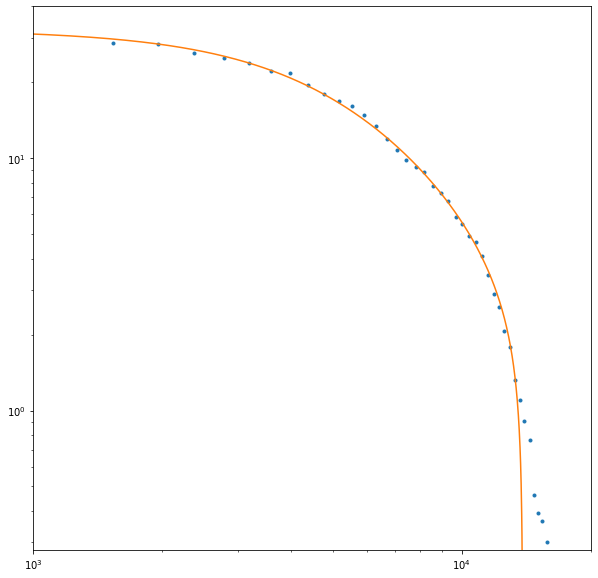

In [617]:
radius_final = np.asarray(xi_sol) * cs / np.sqrt(4.*np.pi*G*rho_center) * 6.68e-14 # AU
vis_final = colden * 2*cs * np.sqrt(rho_center/(4*np.pi*G)) * 6.022e23 / coeff
plt.figure(figsize=(10,10))
plt.plot(df_rau, df_extinction, '.')
plt.xlim([1e3,2e4])
plt.ylim([0.28,40])
plt.xscale('log')
plt.yscale('log')
plt.plot(radius_final, vis_final[idx_xi,:])
plt.show()

In [618]:
print("xi max = {}".format(xi_sol[idx_xi]))
print("Max radius = {}".format(radius_final[idx_xi]))
print("Center to edge density ratio = {}".format(1/rho_contrast[idx_xi]))

xi max = 6.819999999999899
Max radius = 13864.949457379642
Center to edge density ratio = 16.174229226588924


$$ M(R) = \int_0^R 4\pi r^2 \rho(r) dr  = \int_0^R 4\pi r^2 \rho_c e^{-\psi} dr $$
$$ \Rightarrow M(\xi) = \Big(\frac{c_s^2}{G}\Big)^{3/2} \frac{1}{\sqrt{4\pi \rho_c}} \Big[ \xi^2 \frac{d\psi}{d\xi} \Big]_{\xi=\xi_{max}} $$

In [621]:
M_xi_sol = []
for i in range(1, N-1):
    dpsi_dxi = (psi_sol[i+1] - psi_sol[i-1]) / (2*dxi)
    M_xi_sol.append(np.power(xi_sol[i], 2) * dpsi_dxi)
    # m_xi_sol.append(np.sqrt(rho_contrast[i]) * np.power(xi_sol[i], 2) * dpsi_dxi)
M_xi = np.asarray(M_xi_sol) * np.power(cs**2/G, 3./2.) / np.sqrt(4*np.pi*rho_center)
M_xi[idx_xi] / 1.988e33

2.5386916463760065